In [5]:
import os
import pandas as pd 
import numpy as np
import geopandas as gpd

from pyproj import Transformer
from pyproj import CRS, Proj

from osgeo import gdal 
import rasterio
from rasterio.windows import from_bounds
from shapely.geometry import Point
import matplotlib.pyplot as plt


import xarray as xr
import geopy.distance

In [6]:
# Load the generation data
path = os.getcwd() + "\\Raw_Spatial_Data\\Gen 2016-2023_vs edit.xlsx"
gen_data_wet = pd.read_excel(path,"2022")
gen_data_wet.drop(columns=['Export Capacity (MW)'],inplace=True)

gen_data_dry = pd.read_excel(path,"2019")
gen_data_dry.drop(columns=['Export Capacity (MW)'],inplace=True)

### Plant Data

In [7]:
# Load the plant data (head, location, etc.)
path = os.getcwd() + "\\Raw_Spatial_Data\\19.7.2024-NEW UPDATED_Data_lao_231223_NPP_coordinate.xlsx"
data = pd.read_excel(path,'NPDP power plant info')

In [8]:
# PREP OF PLANT DATA
data = data[['SNo', 'East E', 'North N', 'Status', 'PP name', 'New Ose_Name','Fuel Type',
       'Province', 'Region', 'Total capacity (MW)',
       'Domestic Capacity (MW)', 'Export Capacity (MW)',
       'Expected Generation (GWh)',
       'total theoretical possible generation (local) GWh', 'COD (Year)',
       'Exporting country country', 'Head Hydraulic (m)']]

data['East E'] = pd.to_numeric(data['East E'], errors='coerce')
data['North N'] = pd.to_numeric(data['North N'], errors='coerce')

data = data.dropna(subset=['East E', 'North N'])

transformer = Transformer.from_crs("epsg:32648", "epsg:4326", always_xy=True)

def convert_coordinates(easting, northing):
    longitude, latitude = transformer.transform(easting, northing)
    return latitude, longitude

converted_coords = data.apply(
    lambda row: convert_coordinates(row['East E'], row['North N']),
    axis=1
)

data = data.copy()
data[['Latitude', 'Longitude']] = pd.DataFrame(converted_coords.tolist(), index=data.index)
data[['East E','North N','Latitude','Longitude']]

data = data[['SNo', 'New Ose_Name', 'PP name','Status','Fuel Type','Latitude','Longitude','Total capacity (MW)','Domestic Capacity (MW)',
             'Expected Generation (GWh)','total theoretical possible generation (local) GWh',
             'COD (Year)','Head Hydraulic (m)']]
data = data.rename(columns={"COD (Year)": "COD",
                            "PP name": "name",
                            # "Total capacity (MW)": "capacity",
                            "Head Hydraulic (m)": "head"})

data = data[data['Fuel Type'].isin(['Run - Off', 'Reservoir '])]
data['Total capacity (MW)'] = pd.to_numeric(data['Total capacity (MW)'], errors='raise')

data['Fuel Type'] = data['Fuel Type'].str.replace("Reservoir ", "Reservoir")
data.to_excel(r"Raw_Spatial_Data/hydropower_list_seasonal.xlsx", index=False)

### Hydrological Network

In [9]:
# Coordinate Reference Systems
wgs84 = CRS("EPSG:4326")
merc = CRS("EPSG:3395")
merc_pro = Proj("EPSG:3395")

class LocalHydroNetwork:
    def __init__(self, dem_path, flow_path, flow_acc_path):
        self.dem = rasterio.open(dem_path)
        self.flow = rasterio.open(flow_path)
        self.flow_acc = rasterio.open(flow_acc_path)

    def create_local_network(self, point, buffer=0.005):
        minx, miny = point.x - buffer, point.y - buffer
        maxx, maxy = point.x + buffer, point.y + buffer

        window = rasterio.windows.from_bounds(minx, miny, maxx, maxy, self.dem.transform)
        dem_local = self.dem.read(1, window=window)
        flow_local = self.flow.read(1, window=window)
        flow_acc_local = self.flow_acc.read(1, window=window)

        transform = rasterio.windows.transform(window, self.dem.transform)

        nodes, arcs = self._extract_nodes_arcs(dem_local, flow_local, flow_acc_local, transform)
        return nodes, arcs

    def _extract_nodes_arcs(self, dem_local, flow_local, flow_acc_local, transform):
        nodes = []
        arcs = []
        height, width = dem_local.shape
        node_index_map = {}

        for i in range(height):
            for j in range(width):
                x, y = transform * (j, i)
                elevation = dem_local[i, j]
                flow_dir = flow_local[i, j]
                flow_acc = flow_acc_local[i, j]

                current_node = (i, j)
                if current_node not in node_index_map:
                    node_id = len(nodes)
                    node = {
                        'id': node_id,
                        'x': x,
                        'y': y,
                        'elevation': elevation,
                        'flow_acc': flow_acc,
                        'arcs': []
                    }
                    nodes.append(node)
                    node_index_map[current_node] = node_id
                else:
                    node_id = node_index_map[current_node]

                if flow_dir > 0:
                    next_i, next_j = self._flow_direction_to_indices(i, j, flow_dir)
                    if 0 <= next_i < height and 0 <= next_j < width:
                        next_node = (next_i, next_j)
                        if next_node not in node_index_map:
                            next_node_id = len(nodes)
                            next_x, next_y = transform * (next_j, next_i)
                            next_elevation = dem_local[next_i, next_j]
                            next_flow_acc = flow_acc_local[next_i, next_j]

                            next_node_data = {
                                'id': next_node_id,
                                'x': next_x,
                                'y': next_y,
                                'elevation': next_elevation,
                                'flow_acc': next_flow_acc,
                                'arcs': []
                            }
                            nodes.append(next_node_data)
                            node_index_map[next_node] = next_node_id
                        else:
                            next_node_id = node_index_map[next_node]

                        arc = {
                            'start_node': node_id,
                            'end_node': next_node_id,
                            'length': np.hypot(next_i - i, next_j - j)
                        }
                        nodes[node_id]['arcs'].append(arc)
                        arcs.append(arc)

        return nodes, arcs

    def _flow_direction_to_indices(self, i, j, direction):
        if direction == 1:  # East
            return i, j + 1
        elif direction == 2:  # Southeast
            return i + 1, j + 1
        elif direction == 4:  # South
            return i + 1, j
        elif direction == 8:  # Southwest
            return i + 1, j - 1
        elif direction == 16:  # West
            return i, j - 1
        elif direction == 32:  # Northwest
            return i - 1, j - 1
        elif direction == 64:  # North
            return i - 1, j
        elif direction == 128:  # Northeast
            return i - 1, j + 1
        else:
            return i, j  # No direction

    def calculate_head(self, nodes, arcs):
        max_head = 0
        for arc in arcs:
            start_node = nodes[arc['start_node']]
            end_node = nodes[arc['end_node']]
            head = start_node['elevation'] - end_node['elevation']
            if head > max_head:
                max_head = head
        return max_head

    def process_hydropower_plants(self, df, buffer):
        df['head_calculated'] = pd.NA
        for index, row in df.iterrows():
            point = Point(row['Longitude'], row['Latitude'])
            nodes, arcs = self.create_local_network(point, buffer)
            head = self.calculate_head(nodes, arcs)
            df.at[index, 'head_calculated'] = head
        df['head_difference'] = df['head'] - df['head_calculated']
        return df

    def optimize_buffer(self, df, buffer_range):
        best_mae = float('inf')
        best_std = float('inf')
        best_buffer = None
        best_df = None
        
        for buffer in buffer_range:
            df_processed = self.process_hydropower_plants(df.copy(), buffer)
            mae = df_processed['head_difference'].abs().mean()
            std = df_processed['head_difference'].std()
            if mae + std < best_mae + best_std:
                best_mae = mae
                best_std = std
                best_buffer = buffer
                best_df = df_processed
        
        print(f"Optimal Buffer: {best_buffer}")
        print(f"Mean Absolute Error: {best_mae}")
        print(f"Standard Deviation: {best_std}")
        
        return best_df, best_buffer, best_mae, best_std

    def optimize_for_fuel_types(self, df, buffer_range):
        # Optimize only for rows with existing head values
        reservoir_df = df[df['Fuel Type'] == 'Reservoir'].dropna(subset=['head']).copy()
        runoff_df = df[df['Fuel Type'] == 'Run - Off'].dropna(subset=['head']).copy()

        print("\nOptimizing for Reservoir plants...")
        optimized_reservoir_df, optimal_reservoir_buffer, reservoir_mae, reservoir_std = self.optimize_buffer(reservoir_df, buffer_range)
        
        print("\nOptimizing for Run - Off plants...")
        optimized_runoff_df, optimal_runoff_buffer, runoff_mae, runoff_std = self.optimize_buffer(runoff_df, buffer_range)

        return {
            'reservoir': {
                'df': optimized_reservoir_df, 
                'buffer': optimal_reservoir_buffer, 
                'mae': reservoir_mae, 
                'std': reservoir_std
            },
            'runoff': {
                'df': optimized_runoff_df, 
                'buffer': optimal_runoff_buffer, 
                'mae': runoff_mae, 
                'std': runoff_std
            }
        }

    def calculate_and_fill_missing_heads(self, df, reservoir_buffer, runoff_buffer):
        # Process all rows with the optimized buffer sizes
        df_reservoir = self.process_hydropower_plants(df[df['Fuel Type'] == 'Reservoir'].copy(), reservoir_buffer)
        df_runoff = self.process_hydropower_plants(df[df['Fuel Type'] == 'Run - Off'].copy(), runoff_buffer)

        # Combine results back into the original DataFrame
        df_combined = pd.concat([df_reservoir, df_runoff])

        # Fill missing head values in the original DataFrame
        for index, row in df_combined.iterrows():
            if pd.isna(df.at[index, 'head']):
                df.at[index, 'head'] = df_combined.at[index, 'head_calculated']

        return df

In [10]:
path = os.getcwd()
dem_path = path + "\\Raw_Spatial_Data\\hydro_data\\dem_con_asia.tif"
flow_path = path + "\\Raw_Spatial_Data\\hydro_data\\flow_asia.tif"
flow_acc_path = path + "\Raw_Spatial_Data\\hydro_data\\as_acc_3s.tif"
xlsx_file = r"Raw_Spatial_Data/hydropower_list_seasonal.xlsx"

buffer_range = np.linspace(0.00025, 0.005, 101)
hydro_network = LocalHydroNetwork(dem_path, flow_path, flow_acc_path)

df = pd.read_excel(xlsx_file)
results = hydro_network.optimize_for_fuel_types(df, buffer_range)

plant_data = hydro_network.calculate_and_fill_missing_heads(df, results['reservoir']['buffer'], results['runoff']['buffer'])


Optimizing for Reservoir plants...
Optimal Buffer: 0.003385
Mean Absolute Error: 26.0828125
Standard Deviation: 29.08527294557416

Optimizing for Run - Off plants...
Optimal Buffer: 0.003195
Mean Absolute Error: 45.85
Standard Deviation: 84.40090732862258


In [11]:
plant_data_25 = plant_data[plant_data["COD"] <= 2025]
plant_data_30 = plant_data[plant_data["COD"] <= 2030]

In [12]:
gdf_25 = gpd.GeoDataFrame(
    plant_data_25,
    geometry=gpd.points_from_xy(plant_data_25.Longitude, plant_data_25.Latitude)
)
gdf_25.set_crs(epsg=4326, inplace=True)
# gdf_25.to_file("Inputs_GeoH2/Data/hydropower_dams_25.gpkg", layer='dams', driver="GPKG")

gdf_30 = gpd.GeoDataFrame(
    plant_data_30,
    geometry=gpd.points_from_xy(plant_data_30.Longitude, plant_data_30.Latitude)
)
gdf_30.set_crs(epsg=4326, inplace=True)
# gdf_30.to_file("Inputs_GeoH2/Data/hydropower_dams_30.gpkg", layer='dams', driver="GPKG")

,SNo,New Ose_Name,name,Status,Fuel Type,Latitude,Longitude,Total capacity (MW),Domestic Capacity (MW),Expected Generation (GWh),total theoretical possible generation (local) GWh,COD,head,geometry
0,1,PWRHYD001NOR,Nam Ngum 1,Existing,Reservoir,18.530336,102.547646,155.0,155.00,1025.0,1357.800,1971.0,45.5,POINT (102.54765 18.53034)
1,2,PWRHYD002SOU,Xeset1,Existing,Run - Off,15.491752,106.278715,45.0,45.00,180.0,394.200,1991.0,10.0,POINT (106.27872 15.49175)
2,3,PWRHYD003CEN,Theun Hinboun(extension),Existing,Reservoir,18.261088,104.562496,440.0,0.05,2691.0,0.438,2013.0,27.0,POINT (104.5625 18.26109)
3,4,PWRHYD004SOU,Houay Ho,Existing,Reservoir,15.059603,106.764106,152.0,2.00,450.0,17.520,1999.0,79.0,POINT (106.76411 15.0596)
4,5,PWRHYD005NOR,Nam Leuk,Existing,Reservoir,18.437522,102.947408,60.0,60.00,215.0,525.600,2000.0,45.5,POINT (102.94741 18.43752)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,142,PWRHYD119SOU,Houay Palaiy,Expected to be completed after 2027,Reservoir,15.303814,106.001605,26.0,0.00,97.0,0.000,2027.0,10.0,POINT (106.0016 15.30381)
112,168,PWRHYD131SOU,Xekong (Downstream) B,Expected to be completed before 2030,Reservoir,14.851590,106.849223,50.0,NaN,206.3,NaN,2028.0,55.0,POINT (106.84922 14.85159)
113,188,PWRHYD139SOU,Xekong 4A,Expected to be completed after 2030,Reservoir,15.512723,106.787302,175.0,15.00,781.2,131.400,2030.0,53.0,POINT (106.7873 15.51272)
114,189,PWRHYD140SOU,Xekong 4B,Expected to be completed after 2030,Reservoir,15.795484,106.757473,165.0,15.00,749.5,131.400,2030.0,74.0,POINT (106.75747 15.79548)


### Merge Data

In [13]:
# Check for mismatches and display differing rows
overlapping_columns = ['Domestic Capacity (MW)'] # 'Total capacity (MW)', 

# Perform inner merge for comparison
merged_for_comparison = pd.merge(
    plant_data, gen_data_wet,
    left_on='New Ose_Name', right_on='OSeMOSYS tech',
    how='inner',
    suffixes=('_plant', '_wet')
)

# Iterate through overlapping columns to find and display mismatches
for col in overlapping_columns:
    diff_rows = merged_for_comparison[merged_for_comparison[f'{col}_plant'] != merged_for_comparison[f'{col}_wet']]
    
    if not diff_rows.empty:
        print(f"Rows with differing values in column '{col}':")
        display(diff_rows)
    else:
        print(f"No differing values in column '{col}'.")


Rows with differing values in column 'Domestic Capacity (MW)':


,SNo,New Ose_Name,name,Status,Fuel Type,Latitude,Longitude,Total capacity (MW)_plant,Domestic Capacity (MW)_plant,Expected Generation (GWh),...,Jun,Jul,Aug,Sep,Oct,Nov,Dec,OSeMOSYS tech,Total capacity (MW)_wet,Domestic Capacity (MW)_wet
6,9,PWRHYD009CEN,Nam Theun 2,Existing,Reservoir,17.997514,104.952542,1080.0,75.276,6000.0,...,28.608600,31.128700,17.343600,18.516500,15.467000,12.560000,11.684400,PWRHYD009CEN,75.0,75.0
55,76,PWRHYD067CEN,Nam Ngum 1 EX phase 2 (6),Existing,Reservoir,18.531179,102.547716,120.0,40.000,59.0,...,37.457872,24.056480,7.461600,0.000000,0.000000,0.000000,0.000000,PWRHYD067CEN,120.0,120.0
57,81,PWRHYD072SOU,Xelabam,Existing,Run - Off,15.354007,105.833261,13.5,13.500,57.0,...,3.426643,3.681152,3.460402,3.281309,3.570649,3.514803,3.531307,PWRHYD072SOU,13.0,13.0


In [14]:
gen_data_wet = gen_data_wet.drop(columns=['Total capacity (MW)','Domestic Capacity (MW)'])
merged_data_wet = pd.merge(plant_data, gen_data_wet, left_on='New Ose_Name', right_on='OSeMOSYS tech', how='left')
for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
    merged_data_wet[month] = merged_data_wet[month].fillna(0)

gen_data_dry = gen_data_dry.drop(columns=['Total capacity (MW)','Domestic Capacity (MW)'])
merged_data_dry = pd.merge(plant_data, gen_data_dry, left_on='New Ose_Name', right_on='OSeMOSYS tech', how='left')
for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
    merged_data_dry[month] = merged_data_dry[month].fillna(0)

In [15]:
merged_data_wet.columns

Index(['SNo', 'New Ose_Name', 'name', 'Status', 'Fuel Type', 'Latitude',
       'Longitude', 'Total capacity (MW)', 'Domestic Capacity (MW)',
       'Expected Generation (GWh)',
       'total theoretical possible generation (local) GWh', 'COD', 'head',
       'Name', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec', 'OSeMOSYS tech'],
      dtype='object')

### Hourly generation

In [16]:
# Define monthly columns and hours in each month for 2023
monthly_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
hours_in_month = {
    'Jan': 744, 'Feb': 672, 'Mar': 744, 'Apr': 720,
    'May': 744, 'Jun': 720, 'Jul': 744, 'Aug': 744,
    'Sep': 720, 'Oct': 744, 'Nov': 720, 'Dec': 744
}

In [17]:
def calculate_hourly_values(data, monthly_columns, hours_in_month):
    """
    Calculate smoothed hourly generation values (MWh) for each plant.

    Args:
        data (pd.DataFrame): The input dataset containing plant details and monthly generation values.
        monthly_columns (list): List of columns representing monthly generation.
        hours_in_month (dict): Dictionary mapping months to the number of hours.

    Returns:
        pd.DataFrame: Smoothed hourly generation values (time x plants).
    """
    # Initialize a dictionary to store smoothed hourly generation values
    plant_hourly_values = {}

    # Iterate over each plant in the dataset
    for index, row in data.iterrows():
        plant_name = row['name']

        # Generate a list to hold absolute monthly generation values (in MWh)
        monthly_generation_values = []
        for month in monthly_columns:
            monthly_generation = row[month] #* 1000  # Convert GWh to MWh
            monthly_generation_values.append(monthly_generation)

        # Extend time index to include January 2024 for boundary smoothing
        extended_monthly_time_index = pd.date_range(start='2023-01-01', end='2024-01-01', freq='MS')
        extended_monthly_generation_values = monthly_generation_values + [monthly_generation_values[-1]]

        # Create a Series with extended monthly generation values
        extended_monthly_series = pd.Series(data=extended_monthly_generation_values, index=extended_monthly_time_index)

        # Interpolate to create hourly data using cubic interpolation
        hourly_series = extended_monthly_series.resample('h').interpolate(method='cubic')

        # Trim to the full hourly range for 2023 (8760 hours)
        full_time_index = pd.date_range(start='2023-01-01 00:00', end='2023-12-31 23:00', freq='H')
        hourly_series = hourly_series.reindex(full_time_index, method='nearest')

        # Store the plant's smoothed hourly generation values in the dictionary
        plant_hourly_values[plant_name] = hourly_series

    # Combine all plants into a single DataFrame
    smoothed_hourly_values = pd.DataFrame(plant_hourly_values)

    # Drop any remaining NaNs (if any)
    smoothed_hourly_values.dropna(axis=0, how='any', inplace=True)

    return smoothed_hourly_values


In [18]:
hourly_values_wet = calculate_hourly_values(merged_data_wet, monthly_columns, hours_in_month)
hourly_values_dry = calculate_hourly_values(merged_data_dry, monthly_columns, hours_in_month)


In [19]:
hourly_values_wet

,Nam Ngum 1,Xeset1,Theun Hinboun(extension),Houay Ho,Nam Leuk,Nam Mang 3,Xeset 2,Nam Lik 1-2,Nam Theun 2,Nam Ngum 2,...,Xekong 4A,Xekong 4B,Luang Prabang,Pak Beng,Pak Lai (Nam khong),Xekatam,Nam Xum 4,Xekong 5,Sanakham,Nam Bak 1
2023-01-01 00:00:00,65.182010,5.977970,0.0,0.0,10.510350,7.660000,7.556639,32.921430,9.775510,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 01:00:00,65.125078,5.972454,0.0,0.0,10.511998,7.670964,7.548774,32.852394,9.735016,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 02:00:00,65.068305,5.966947,0.0,0.0,10.513625,7.681891,7.540922,32.783516,9.694686,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 03:00:00,65.011691,5.961450,0.0,0.0,10.515231,7.692782,7.533083,32.714797,9.654520,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 04:00:00,64.955236,5.955961,0.0,0.0,10.516817,7.703636,7.525256,32.646236,9.614517,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,45.940154,8.586835,0.0,0.0,1.750160,5.828473,11.211716,17.838793,11.683282,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 20:00:00,45.935062,8.583789,0.0,0.0,1.735455,5.822834,11.208671,17.859737,11.683506,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 21:00:00,45.929951,8.580725,0.0,0.0,1.720688,5.817174,11.205604,17.880750,11.683729,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 22:00:00,45.924820,8.577642,0.0,0.0,1.705858,5.811493,11.202514,17.901832,11.683953,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create Baseload Profile

In [20]:
gdf_areas = gpd.read_file(r'Raw_Spatial_Data\areas_laos.geojson')

In [21]:
def assign_zones_to_plants(plants_gdf, areas_gdf, zone_column="Area_new24"):
    """
    Assign zones to hydropower plants based on their spatial location.

    Args:
        plants_gdf (GeoDataFrame): GeoDataFrame containing hydropower plant locations.
        areas_gdf (GeoDataFrame): GeoDataFrame containing zone polygons with the `zone_column`.
        zone_column (str): Column name in `areas_gdf` representing zones.

    Returns:
        GeoDataFrame: Updated plants GeoDataFrame with assigned zones.
    """
    # Ensure both GeoDataFrames have the same CRS
    plants_gdf = plants_gdf.to_crs(areas_gdf.crs)

    # Perform spatial join to assign zones
    plants_with_zones = gpd.sjoin(plants_gdf, areas_gdf[[zone_column, "geometry"]], how="left", predicate="intersects")

    # Drop duplicate geometry columns if any
    plants_with_zones = plants_with_zones.drop(columns=["index_right"])

    return plants_with_zones


In [45]:
# Load spatial data
plants_gdf = gdf_30 # Replace with gdf30 if needed
areas_gdf = gpd.read_file(r'Raw_Spatial_Data\areas_laos.geojson')

# Step 1: Assign zones to plants
plants_with_zones = assign_zones_to_plants(plants_gdf, areas_gdf)


In [46]:
def load_and_process_load_profiles(excel_path, sheets, monthly_columns, hours_in_month):
    """
    Load and process load profiles from an Excel file for each zone.

    Args:
        excel_path (str): Path to the Excel file containing load profiles.
        sheets (dict): Mapping of zone names to sheet names in the Excel file.
        monthly_columns (list): List of columns representing months.
        hours_in_month (dict): Dictionary mapping months to the number of hours.

    Returns:
        dict: A dictionary mapping zone names to expanded hourly load profiles (pd.Series).
    """
    zone_profiles = {}

    for zone, sheet in sheets.items():
        # Load the sheet
        zone_data = pd.read_excel(excel_path, sheet_name=sheet, index_col=0)

        # Expand the daily profile for each month
        hourly_demand = []
        for month_idx, hours in enumerate(hours_in_month.values()):
            avg_day_profile = zone_data.iloc[month_idx,:]  # Get daily values for the month
            expanded_monthly_profile = list(avg_day_profile) * (hours // 24)
            hourly_demand.extend(expanded_monthly_profile)

        # Create a Series with the hourly demand
        hourly_demand_series = pd.Series(
            hourly_demand,
            index=pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="H")
        )

        # Store the Series in the dictionary
        zone_profiles[zone] = hourly_demand_series

    return zone_profiles



In [47]:
# File path and sheet mappings
excel_path = r'Raw_Spatial_Data\Load_profile.xlsx'
sheets = {
    'north': 'TimeSlices_Northern',
    'centre': 'TimeSlices_Central',
    'south': 'TimeSlices_Southern'
}

# Load and process load profiles
zone_profiles = load_and_process_load_profiles(
    excel_path=excel_path,
    sheets=sheets,
    monthly_columns=monthly_columns,
    hours_in_month=hours_in_month
)

In [48]:
# 2025 - 1.367125525
# 2030 - 1.804013066

percentage = 1.804013066   # Your percentage multiplier

# Multiply each DataFrame in the dictionary by the percentage
zone_profiles = {zone: df * percentage for zone, df in zone_profiles.items()}

# Verify the result
zone_profiles


{'north': 2023-01-01 00:00:00    726.518357
 2023-01-01 01:00:00    717.419088
 2023-01-01 02:00:00    714.237903
 2023-01-01 03:00:00    713.111411
 2023-01-01 04:00:00    723.029739
                           ...    
 2023-12-31 19:00:00    887.342991
 2023-12-31 20:00:00    832.711481
 2023-12-31 21:00:00    793.333775
 2023-12-31 22:00:00    760.164609
 2023-12-31 23:00:00    742.942977
 Freq: H, Length: 8760, dtype: float64,
 'centre': 2023-01-01 00:00:00    501.952979
 2023-01-01 01:00:00    493.922212
 2023-01-01 02:00:00    487.309573
 2023-01-01 03:00:00    487.870039
 2023-01-01 04:00:00    499.361350
                           ...    
 2023-12-31 19:00:00    851.494302
 2023-12-31 20:00:00    793.338405
 2023-12-31 21:00:00    732.592040
 2023-12-31 22:00:00    676.122574
 2023-12-31 23:00:00    652.953890
 Freq: H, Length: 8760, dtype: float64,
 'south': 2023-01-01 00:00:00    105.619728
 2023-01-01 01:00:00    104.827708
 2023-01-01 02:00:00    104.193393
 2023-01-01 03:00

In [49]:
# def distribute_and_subtract_demand_v2(hourly_generation, zone_profiles, plants_data, zone_column):
#     """
#     Distribute zone-specific hourly demand across plants within each zone,
#     and subtract demand from the plants' generation.

#     Args:
#         hourly_generation (pd.DataFrame): Hourly generation values for all plants (time x plants).
#         zone_profiles (dict): Dictionary mapping zones to their expanded hourly load profiles.
#         plants_data (GeoDataFrame): Plant data containing assigned zones and capacities.
#         zone_column (str): Column name indicating plant zone ('north', 'centre', 'south').

#     Returns:
#         pd.DataFrame: Net hourly generation values (time x plants).
#     """
#     # Initialize a DataFrame to store net generation
#     net_generation = hourly_generation.copy()

#     # Iterate over each zone
#     for zone, hourly_zone_demand in zone_profiles.items():
#         # Filter plants belonging to the current zone
#         plants_in_zone = plants_data[plants_data[zone_column] == zone]
#         zone_plant_names = plants_in_zone['name']
#         total_capacity_zone = plants_in_zone['Domestic Capacity (MW)'].sum()
#         print(total_capacity_zone)

#         if total_capacity_zone == 0:
#             continue  # Skip if no capacity in the zone

#         # Distribute demand among plants in the zone based on their capacities
#         for plant in zone_plant_names:
#             plant_capacity = plants_in_zone.loc[plants_in_zone['name'] == plant, 'Domestic Capacity (MW)'].values[0]
#             fractional_demand = (plant_capacity / total_capacity_zone) * hourly_zone_demand

#             # Subtract demand from the plant's generation
#             net_generation[plant] -= fractional_demand

#     return net_generation


In [50]:
def distribute_and_subtract_demand_v2(hourly_generation, zone_profiles, plants_data, zone_column):
    """
    Distribute zone-specific hourly demand across plants within each zone,
    and subtract demand from the plants' generation using dynamic hourly capacity.

    Args:
        hourly_generation (pd.DataFrame): Hourly generation values for all plants (time x plants).
        zone_profiles (dict): Dictionary mapping zones to their expanded hourly load profiles.
        plants_data (GeoDataFrame): Plant data containing assigned zones.
        zone_column (str): Column name indicating plant zone ('north', 'centre', 'south').

    Returns:
        pd.DataFrame: Net hourly generation values (time x plants).
    """
    # Initialize a DataFrame to store net generation
    net_generation = hourly_generation.copy()

    # Iterate over each zone
    for zone, hourly_zone_demand in zone_profiles.items():
        # Filter plants belonging to the current zone
        plants_in_zone = plants_data[plants_data[zone_column] == zone]
        zone_plant_names = plants_in_zone['name']

        # If no plants in this zone, skip it
        if zone_plant_names.empty:
            continue

        # Extract hourly generation for the plants in the current zone
        zone_hourly_generation = hourly_generation[zone_plant_names]

        # Calculate the total hourly generation for the zone
        total_hourly_generation = zone_hourly_generation.sum(axis=1)

        # Avoid division by zero: replace zeros with NaN temporarily
        total_hourly_generation.replace(0, float('nan'), inplace=True)

        # Distribute demand among plants in the zone based on their hourly generation
        for plant in zone_plant_names:
            # Fractional demand based on hourly generation share
            fractional_demand = (
                (zone_hourly_generation[plant] / total_hourly_generation) * hourly_zone_demand
            )

            # Fill NaN values in fractional_demand with 0 (for cases where total_hourly_generation was 0)
            fractional_demand.fillna(0, inplace=True)

            # Subtract demand from the plant's generation
            net_generation[plant] -= fractional_demand

    return net_generation


In [51]:
# Distribute demand and subtract from generation
net_generation_wet = distribute_and_subtract_demand_v2(
    hourly_generation=hourly_values_wet,  # Hourly generation DataFrame
    zone_profiles=zone_profiles,         # Zone-specific hourly demand profiles
    plants_data=plants_with_zones,       # Plant data with zones
    zone_column="Area_new24"             # Zone column name
)

net_generation_dry = distribute_and_subtract_demand_v2(
    hourly_generation=hourly_values_dry,  # Hourly generation DataFrame
    zone_profiles=zone_profiles,         # Zone-specific hourly demand profiles
    plants_data=plants_with_zones,       # Plant data with zones
    zone_column="Area_new24"             # Zone column name
)

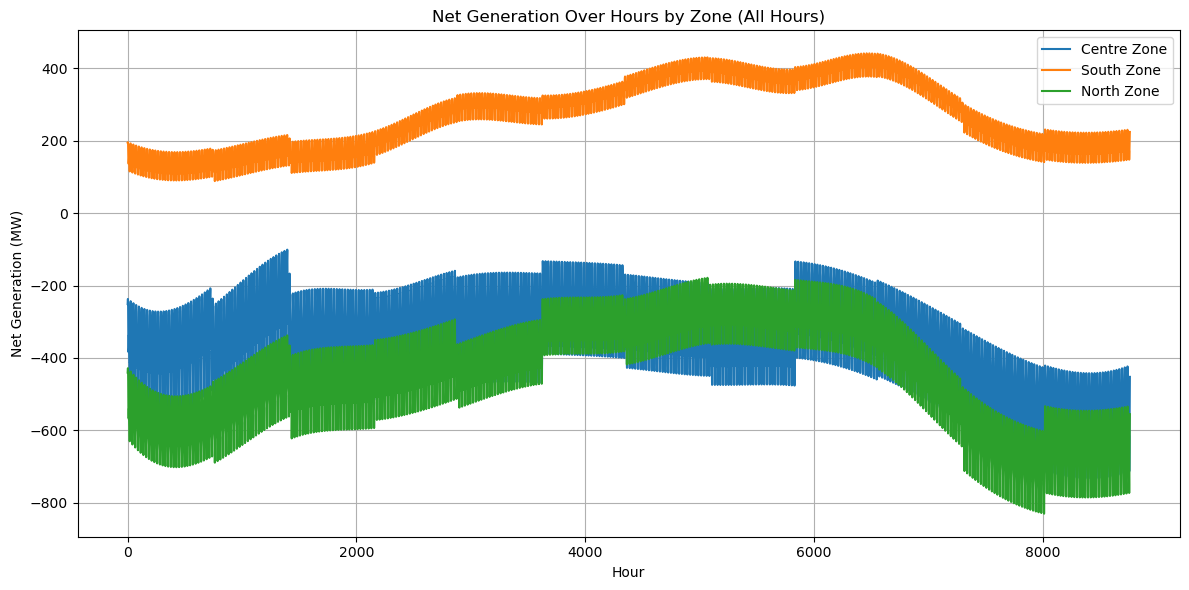

In [52]:
def plot_net_generation(net_generation, plants_data, zone_column, max_hours=None):
    """
    Plot the net generation over time for each zone with an optional hour limit.

    Args:
        net_generation (pd.DataFrame): Net hourly generation values (time x plants).
        plants_data (GeoDataFrame): Plant data containing assigned zones.
        zone_column (str): Column name indicating plant zone ('north', 'centre', 'south').
        max_hours (int, optional): Maximum number of hours to display. Defaults to None (show all hours).

    Returns:
        None
    """
    # Limit the data to the first `max_hours` if specified
    if max_hours:
        net_generation = net_generation.iloc[:max_hours]

    # Create an hour index (1 to total hours in net_generation)
    hour_index = range(1, len(net_generation) + 1)

    # Group plants by zone
    zones = plants_data[zone_column].unique()

    plt.figure(figsize=(12, 6))

    for zone in zones:
        # Get plants in this zone
        plants_in_zone = plants_data[plants_data[zone_column] == zone]['name']

        # Aggregate net generation for the zone
        zone_net_generation = net_generation[plants_in_zone].sum(axis=1)

        # Plot the zone's net generation
        plt.plot(hour_index, zone_net_generation, label=f"{zone.capitalize()} Zone")

    # Customize the plot
    plt.title(f"Net Generation Over Hours by Zone ({'All Hours' if not max_hours else f'First {max_hours} Hours'})")
    plt.xlabel("Hour")
    plt.ylabel("Net Generation (MW)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Plot only the first 1000 hours
plot_net_generation(
    net_generation=net_generation_wet,
    plants_data=plants_with_zones,
    zone_column="Area_new24",
    # max_hours=700
)

### Capacity Factor Calculation

In [53]:
def calculate_capacity_factors(hourly_values, plant_capacities):
    """
    Calculate capacity factors by normalizing hourly generation values.

    Args:
        hourly_values (pd.DataFrame): Smoothed hourly generation values (time x plants).
        plant_capacities (pd.Series): Series mapping plant names to their capacities (in MW).

    Returns:
        pd.DataFrame: Capacity factors (time x plants).
    """
    # Normalize hourly generation values by plant capacities to compute capacity factors
    capacity_factors = hourly_values.divide(plant_capacities, axis='columns')

    # Clip capacity factors to be within [0, 1]
    capacity_factors = capacity_factors.clip(lower=0, upper=1)

    return capacity_factors


In [54]:
# Step 2: Calculate capacity factors
plant_capacities_wet = merged_data_wet.set_index('name')['Total capacity (MW)']
plant_capacities_dry = merged_data_dry.set_index('name')['Total capacity (MW)']

capacity_factors_wet = calculate_capacity_factors(net_generation_wet, plant_capacities_wet)
capacity_factors_dry = calculate_capacity_factors(net_generation_dry, plant_capacities_dry)

In [55]:
# def calculate_capacity_factors(data, monthly_columns, hours_in_month):
#     # Initialize a dictionary to store smoothed hourly capacity factors for each plant
#     plant_capacity_factors = {}

#     # Iterate over each plant in the dataset
#     for index, row in data.iterrows():
#         plant_name = row['name']
#         plant_capacity = row['Total capacity (MW)']

#         # Generate a list to hold monthly capacity factors for the plant
#         monthly_capacity_factors = []
#         for month in monthly_columns:
#             monthly_generation = row[month] * 1000  # Convert GWh to MWh
#             monthly_capacity_factor = (monthly_generation / hours_in_month[month]) / plant_capacity
#             monthly_capacity_factors.append(monthly_capacity_factor)

#         # Extend time index to include January 2024 for boundary smoothing
#         extended_monthly_time_index = pd.date_range(start='2023-01-01', end='2024-01-01', freq='MS')
#         extended_monthly_capacity_factors = monthly_capacity_factors + [monthly_capacity_factors[-1]]

#         # Create a Series with extended monthly capacity factors
#         extended_monthly_series = pd.Series(data=extended_monthly_capacity_factors, index=extended_monthly_time_index)

#         # Interpolate to create hourly data using cubic interpolation
#         hourly_series = extended_monthly_series.resample('h').interpolate(method='cubic')

#         # Trim to the full hourly range for 2023 (8760 hours)
#         full_time_index = pd.date_range(start='2023-01-01 00:00', end='2023-12-31 23:00', freq='H')
#         hourly_series = hourly_series.reindex(full_time_index, method='nearest')

#         # Store the plant's smoothed hourly capacity factors in the dictionary
#         plant_capacity_factors[plant_name] = hourly_series

#     # Combine all plants into a single DataFrame
#     smoothed_capacity_factors = pd.DataFrame(plant_capacity_factors)

#     # Clip capacity factors to be within [0, 1]
#     smoothed_capacity_factors = smoothed_capacity_factors.clip(lower=0, upper=1)

#     # Drop any remaining NaNs (if any)
#     smoothed_capacity_factors.dropna(axis=0, how='any', inplace=True)

#     return smoothed_capacity_factors


In [56]:
# # Step 1: Calculate capacity factors
# smoothed_capacity_factors_wet = calculate_capacity_factors(merged_data_wet, monthly_columns, hours_in_month)
# smoothed_capacity_factors_dry = calculate_capacity_factors(merged_data_dry, monthly_columns, hours_in_month)

### Calculate average capacity factors for empty plants 

In [57]:
laos_hydrobasins = gpd.read_file('Raw_Spatial_Data\hydro_data\hydrobasins\hybas_as_lev08_v1c\hybas_as_lev08_v1c.shp')

In [58]:
plants_gdf_wet = gpd.GeoDataFrame(
    data=merged_data_wet,  # Or merged_data_dry
    geometry=gpd.points_from_xy(merged_data_wet['Longitude'], merged_data_wet['Latitude']),
    crs=laos_hydrobasins.crs
)

# Step 2: Map plants to basins
plants_with_basins_wet = gpd.sjoin(plants_gdf_wet, laos_hydrobasins, how='left', predicate='intersects')
plant_to_basin_mapping_wet = plants_with_basins_wet.set_index('name')['HYBAS_ID']

plants_gdf_dry = gpd.GeoDataFrame(
    data=merged_data_dry,  # Or merged_data_dry
    geometry=gpd.points_from_xy(merged_data_dry['Longitude'], merged_data_dry['Latitude']),
    crs=laos_hydrobasins.crs
)
plants_with_basins_dry = gpd.sjoin(plants_gdf_dry, laos_hydrobasins, how='left', predicate='intersects')
plant_to_basin_mapping_dry = plants_with_basins_dry.set_index('name')['HYBAS_ID']

In [59]:
# def update_zero_rows_with_basin_average(capacity_factors, plant_to_basin_mapping):
#     # Identify plants (columns) with all 0s across all hours
#     zero_plants = (capacity_factors == 0).all(axis=0)
#     # Iterate over each basin and calculate the basin average
#     for basin in plant_to_basin_mapping.unique():
#         # Get plants in this basin
#         plants_in_basin = plant_to_basin_mapping[plant_to_basin_mapping == basin].index

#         # Get rows corresponding to these plants
#         rows_in_basin = capacity_factors[plants_in_basin]

#         # Calculate the basin average for non-zero plants
#         basin_average = rows_in_basin.loc[:, ~zero_plants[plants_in_basin]].mean(axis=1)

#         # Update plants with all 0s for this basin
#         for plant in plants_in_basin:
#             if zero_plants[plant]:
#                 capacity_factors[plant] = basin_average

#     return capacity_factors

# # Step 3: Update zero rows
# updated_capacity_factors_wet = update_zero_rows_with_basin_average(capacity_factors_wet, plant_to_basin_mapping_wet)
# updated_capacity_factors_dry = update_zero_rows_with_basin_average(capacity_factors_dry, plant_to_basin_mapping_dry)

In [60]:
def update_zero_rows_with_basin_average(capacity_factors, plant_to_basin_mapping, plants_location_data, max_radius_km=100):
    """
    Update plants with all 0s by first using basin averages, and for remaining zero plants, incrementally
    expand the radius to find nearby plants in 10 km steps.

    Args:
        capacity_factors (pd.DataFrame): Capacity factors with plants as columns and time as rows.
        plant_to_basin_mapping (pd.Series): Mapping of plants to their basins.
        plants_location_data (pd.DataFrame): DataFrame with plant names, latitudes, and longitudes.
        max_radius_km (float): Maximum radius for searching nearby plants.

    Returns:
        pd.DataFrame: Updated capacity factors.
    """
    # Identify plants (columns) with all 0s across all hours
    zero_plants = (capacity_factors == 0).all(axis=0)

    # Step 1: Basin Averages
    for basin in plant_to_basin_mapping.unique():
        # Get plants in this basin
        plants_in_basin = plant_to_basin_mapping[plant_to_basin_mapping == basin].index

        # Get rows corresponding to these plants
        rows_in_basin = capacity_factors[plants_in_basin]

        # Calculate the basin average for non-zero plants
        basin_average = rows_in_basin.loc[:, ~zero_plants[plants_in_basin]].mean(axis=1)

        # Update plants with all 0s for this basin
        for plant in plants_in_basin:
            if zero_plants[plant]:
                if not basin_average.isna().all():
                    # Use basin average for the plant
                    capacity_factors[plant] = basin_average

    # Recompute zero plants after basin updates
    zero_plants = (capacity_factors == 0).all(axis=0) | capacity_factors.isna().all(axis=0)

    # Step 2: Incremental Radius Expansion for Remaining Zero Plants
    remaining_zero_plants = zero_plants[zero_plants].index  # Plants still with all 0s
    for radius_km in range(10, max_radius_km + 10, 10):
        for plant in remaining_zero_plants:
            if zero_plants[plant]:
                plant_location = plants_location_data.loc[plant]
                nearby_plants = []

                # Find nearby plants within the current radius
                for other_plant, location in plants_location_data.iterrows():
                    if other_plant != plant:
                        dist = geopy.distance.distance(
                            (plant_location['Latitude'], plant_location['Longitude']),
                            (location['Latitude'], location['Longitude'])
                        ).km
                        if dist <= radius_km:
                            nearby_plants.append(other_plant)

                # Calculate the average from nearby plants
                if nearby_plants:
                    nearby_average = capacity_factors[nearby_plants].loc[:, ~zero_plants[nearby_plants]].mean(axis=1)
                    if not nearby_average.isna().all():
                        capacity_factors[plant] = nearby_average
                        zero_plants[plant] = False  # Mark plant as updated

        # Recompute remaining zero plants after each radius increment
        remaining_zero_plants = zero_plants[zero_plants].index

        # If no zero plants remain, exit the loop
        if remaining_zero_plants.empty:
            break

    return capacity_factors


In [61]:
# Example max radius for nearby plants
max_radius_km = 100

# Update capacity factors for smoothed_capacity_factors_wet
updated_capacity_factors_wet = update_zero_rows_with_basin_average(
    capacity_factors=capacity_factors_wet,
    plant_to_basin_mapping=plant_to_basin_mapping_wet,
    plants_location_data=merged_data_wet[['name', 'Latitude', 'Longitude']].set_index('name'),
    max_radius_km=max_radius_km
)

updated_capacity_factors_dry = update_zero_rows_with_basin_average(
    capacity_factors=capacity_factors_dry,
    plant_to_basin_mapping=plant_to_basin_mapping_dry,
    plants_location_data=merged_data_dry[['name', 'Latitude', 'Longitude']].set_index('name'),
    max_radius_km=max_radius_km
)

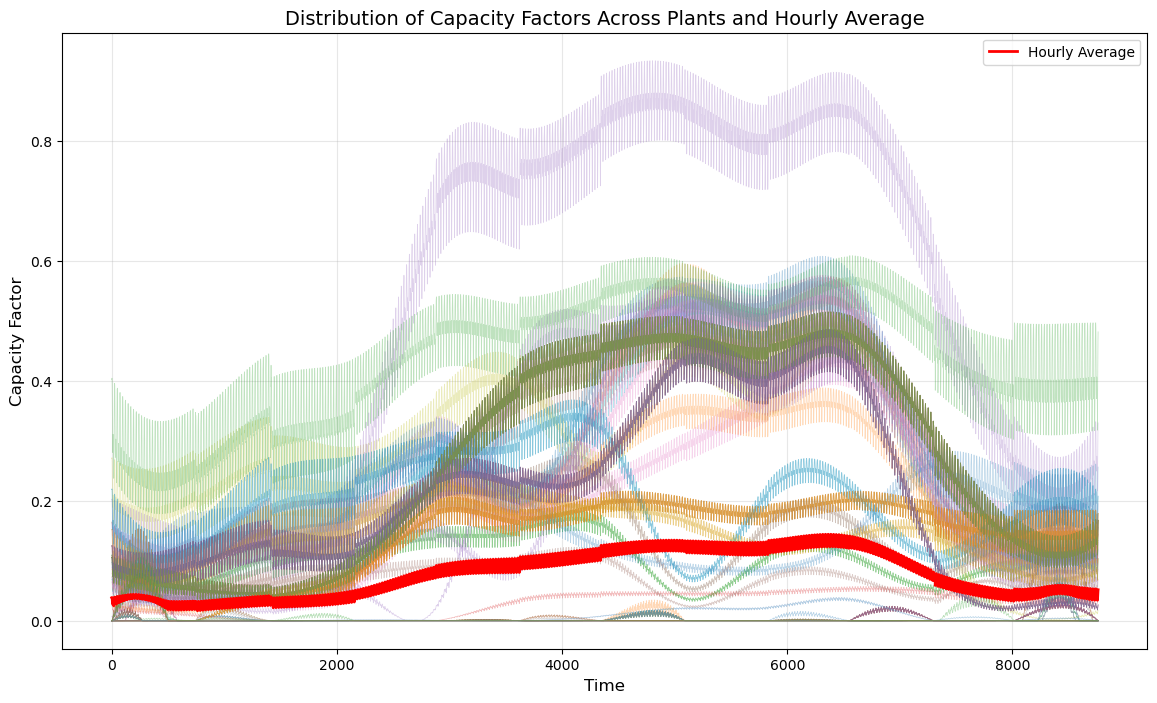

In [62]:
def plot_capacity_factors(capacity_factor):
    """
    Visualize capacity factors for a single year with hours (1 to 8760) on the x-axis.

    Args:
        capacity_factor (pd.DataFrame): DataFrame of capacity factors (time x plants).

    Returns:
        None
    """
    # Calculate the average capacity factor for each hour across all plants
    hourly_average = capacity_factor.mean(axis=1)

    # Generate an x-axis with hours (1 to 8760)
    hours_in_year = range(1, len(capacity_factor) + 1)

    # Set up the figure and axis
    plt.figure(figsize=(14, 8))

    # Plot the individual capacity factors for each plant as transparent lines
    for plant in capacity_factor.columns:
        plt.plot(hours_in_year, capacity_factor[plant], alpha=0.3, linewidth=0.5, label='_nolegend_')

    # Plot the hourly average capacity factor as a bold line
    plt.plot(hours_in_year, hourly_average.values, color='red', label='Hourly Average', linewidth=2)

    # Add title, labels, and legend
    plt.title('Distribution of Capacity Factors Across Plants and Hourly Average', fontsize=14)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Capacity Factor', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # Display the plot
    plt.show()

    # Optionally, save the plot to a file
    # plt.savefig("capacity_factor_distribution.png", dpi=300)

plot_capacity_factors(updated_capacity_factors_wet)


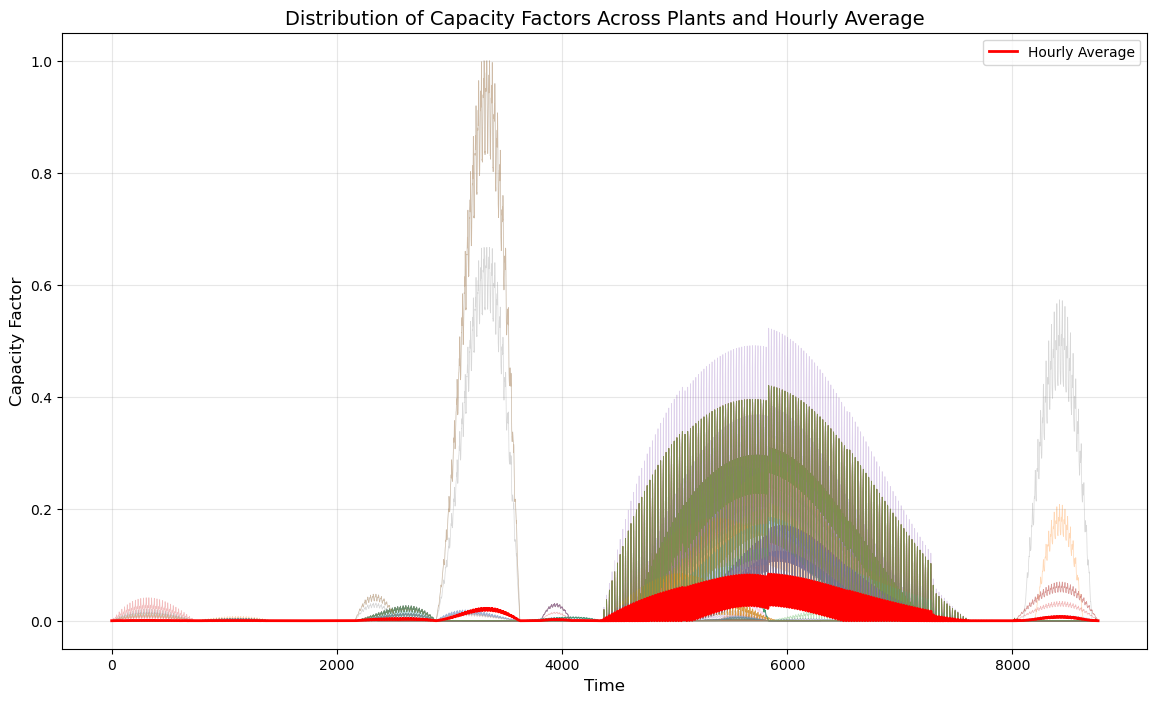

In [63]:
plot_capacity_factors(updated_capacity_factors_dry)

### Filter for scenarios

In [64]:
def filter_capacity_factors_by_cod(capacity_factors, merged_data, year_threshold):
    """
    Filters capacity factors DataFrame based on COD values in the merged data.

    Args:
        capacity_factors (pd.DataFrame): The capacity factors DataFrame (time x plants).
        merged_data (pd.DataFrame): The merged data containing the 'name' and 'COD' columns.
        year_threshold (int): The maximum COD year to include.

    Returns:
        pd.DataFrame: The filtered capacity factors DataFrame.
    """
    # Extract valid plants with COD <= year_threshold
    valid_plants = merged_data.loc[
        (merged_data['COD'] <= year_threshold) & (~merged_data['COD'].isna()),
        'name'
    ]

    # Filter capacity factors to include only valid plants
    filtered_capacity_factors = capacity_factors[valid_plants]

    return filtered_capacity_factors

# First Filter: COD <= 2025
filtered_capacity_factors_wet_2025 = filter_capacity_factors_by_cod(
    capacity_factors=updated_capacity_factors_wet,
    merged_data=merged_data_wet,
    year_threshold=2025
)

filtered_capacity_factors_dry_2025 = filter_capacity_factors_by_cod(
    capacity_factors=updated_capacity_factors_dry,
    merged_data=merged_data_dry,
    year_threshold=2025
)

# Second Filter: COD <= 2030 (starting from the <= 2025 filtered data)
filtered_capacity_factors_wet_2030 = filter_capacity_factors_by_cod(
    capacity_factors=updated_capacity_factors_wet,
    merged_data=merged_data_wet,
    year_threshold=2030
)

filtered_capacity_factors_dry_2030 = filter_capacity_factors_by_cod(
    capacity_factors=updated_capacity_factors_dry,
    merged_data=merged_data_dry,
    year_threshold=2030
)


In [65]:
def convert_to_xarray(capacity_factors, time_index):
    # Convert the DataFrame to an xarray DataArray
    capacity_factor_array = xr.DataArray(
        data=capacity_factors.values,
        dims=['time', 'plant'],
        coords={'time': time_index, 'plant': capacity_factors.columns}
    )
    return capacity_factor_array

# Step 4: Convert to xarray
time_index = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='H')
capacity_factor_array_wet_2025 = convert_to_xarray(filtered_capacity_factors_wet_2025, time_index)
capacity_factor_array_dry_2025 = convert_to_xarray(filtered_capacity_factors_dry_2025, time_index)

capacity_factor_array_wet_2030 = convert_to_xarray(filtered_capacity_factors_wet_2030, time_index)
capacity_factor_array_dry_2030 = convert_to_xarray(filtered_capacity_factors_dry_2030, time_index)

In [66]:
capacity_factor_array = capacity_factor_array_wet_2030
# capacity_factor_array = capacity_factor_array_wet
count_ones = (capacity_factor_array == 0).sum().item()
total_values = capacity_factor_array.size
percentage_ones = (count_ones / total_values) * 100

print(f"Total number of 1s: {count_ones}")
print(f"Percentage of 1s: {percentage_ones:.2f}%")

Total number of 1s: 537868
Percentage of 1s: 52.93%


### Saving file as nc

In [67]:
# Save an xarray.DataArray or xarray.Dataset
# capacity_factor_array_wet_2025.to_netcdf("Inputs_GeoH2/Data/capacity_factors_wet_2025.nc")
# capacity_factor_array_dry_2025.to_netcdf("Inputs_GeoH2/Data/capacity_factors_dry_2025.nc")

capacity_factor_array_wet_2030.to_netcdf("Inputs_GeoH2/Data/capacity_factors_wet_2030.nc")
capacity_factor_array_dry_2030.to_netcdf("Inputs_GeoH2/Data/capacity_factors_dry_2030.nc")


### Prepare hydropower.geojson files for different scenarios

In [45]:
merged_data_dry

,SNo,New Ose_Name,name,Status,Fuel Type,Latitude,Longitude,Total capacity (MW),Domestic Capacity (MW),Expected Generation (GWh),...,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,OSeMOSYS tech
0,1,PWRHYD001NOR,Nam Ngum 1,Existing,Reservoir,18.530336,102.547646,155.0,155.00,1025.0,...,98.576360,89.26243,83.38793,59.38785,27.15516,18.00623,12.85250,13.14753,20.47648,PWRHYD001NOR
1,2,PWRHYD002SOU,Xeset1,Existing,Run - Off,15.491752,106.278715,45.0,45.00,180.0,...,3.164270,5.26834,3.92330,14.08608,32.97802,30.78612,21.96671,12.22374,6.57894,PWRHYD002SOU
2,3,PWRHYD003CEN,Theun Hinboun(extension),Existing,Reservoir,18.261088,104.562496,440.0,0.05,2691.0,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
3,4,PWRHYD004SOU,Houay Ho,Existing,Reservoir,15.059603,106.764106,152.0,2.00,450.0,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
4,5,PWRHYD005NOR,Nam Leuk,Existing,Reservoir,18.437522,102.947408,60.0,60.00,215.0,...,12.785582,12.84383,18.57901,10.36638,14.71953,16.70794,15.27062,13.93580,7.69474,PWRHYD005NOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,197,PWRHYD148SOU,Xekatam,Expected to be completed after 2030,Reservoir,15.136138,106.593269,81.0,81.00,299.0,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
119,202,PWRHYD153NOR,Nam Xum 4,Expected to be completed after 2030,Reservoir,20.305807,104.171948,150.0,150.00,343.0,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
120,250,PWRHYD201SOU,Xekong 5,Expected to be completed after 2030,Reservoir,16.000547,106.961355,330.0,330.00,1502.0,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
121,266,PWRHYD217NOR,Sanakham,Expected to be completed after 2030,Run - Off,17.815526,101.538460,660.0,10.00,3696.0,...,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,NaN
